# 8장. 상관분석과 회귀분석

### 8.1. 상관분석

In [2]:
import pandas
from scipy import stats
import matplotlib.pyplot as plt
import seaborn # 격자 위에 파란 점 찍게 해주는 형식 지원 (필수 아님)

seaborn.set(rc = {'figure.figsize': (3, 3)})
possum = pandas.read_csv("possum.txt", sep = "\t")

seaborn.relplot(x = 'totalL', y = 'headL', data = possum)
plt.show()

<Figure size 500x500 with 1 Axes>

In [3]:
t, p = stats.pearsonr(possum['headL'], possum['totalL'])
print("Pearson's correlation coefficient: %s, p-value: %s" % (t, p))

Pearson's correlation coefficient: 0.6910936973935056, p-value: 4.680578654379385e-16


### 8.2. 단순선형회귀모형

- **회귀식의 적합 체크**
    - `statsmodels.formula.api`의 `ols` 함수
    - 유의성 검정 결과 summary
        - Df Residuals: SSE의 자유도
        - Df model: SSR의 자유도
        - R-squared: 결정계수 (전체 y의 변동 중 회귀직선에 의해 설명되는 변동이 47.8%이다)
        - Adj. R-squared: 나중에 다시
        - F-statistic: 귀무가설 하에서의 F값
        - Prob: F분포에서의 유의확률
    - 회귀분석에 사용된 formula
        - Intercept: Alpha hat 
            - 회귀변수에 대한 추정치 = 42.7
        - totalL: beta hat 
            - 회귀계수에 대한 추정치 = 0.57
            - std err
            - t통계량
            - 95% 신뢰구간
    - 다음 table은 생략. 몰라도 됨
    
- **모수에 대한 신뢰구간만 따로 구하기**
    - `model.conf_int()`로 하면 따로 떼어내어 볼 수 있음

- **평균 반응에 대한 추론** 
    - 내가 원하는 x의 위치에 대한 y의 평균 위치 신뢰구간
    - 신뢰구간 y^ +- t a/2 (n-2) * ^S.E(y^)
    - mean_se: ^S.E(y hat)

In [5]:
from statsmodels.formula.api import ols

model = ols("headL ~ totalL", possum).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  headL   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     93.26
Date:                Wed, 27 Nov 2019   Prob (F-statistic):           4.68e-16
Time:                        13:33:14   Log-Likelihood:                -245.75
No. Observations:                 104   AIC:                             495.5
Df Residuals:                     102   BIC:                             500.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     42.7098      5.173      8.257      0.0

In [6]:
model.conf_int()

,0,1
Intercept,32.449541,52.970045
totalL,0.455230,0.690573


In [9]:
# totalL 84, 88, 92 값들에 대해 계산을 해보겠다
model.get_prediction(exog = dict(totalL = [84, 88, 92])).summary_frame(alpha = 0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,90.833501,0.313588,90.211501,91.455501,85.648251,96.018751
1,93.125106,0.260174,92.609052,93.641161,87.951495,98.298717
2,95.416711,0.386869,94.649358,96.184064,90.212024,100.621398


### 8.3. 잔차분석

2가지

1. 잔차도
    - fitted 값이 증가함에 따라 residual이 증감하는 선형성 보이는가? (안보여야 가정 성립)
2. 정규성
    - QQ plot
    - shapiro test

In [10]:
import statsmodels.api as sm

table = sm.stats.anova_lm(model, typ=2)
print(table)

              sum_sq     df          F        PR(>F)
totalL    628.148138    1.0  93.256604  4.680579e-16
Residual  687.040996  102.0        NaN           NaN


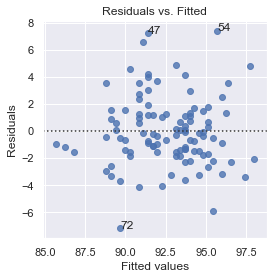

In [12]:
import seaborn
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import ProbPlot

f = model.fittedvalues
r = model.resid
ar = np.abs(r)

ar_sort = ar.sort_values(ascending = False)
top_3_ar = ar_sort[0:3] # top 3 absolute residuals

seaborn.set(rc = {'figure.figsize': (4,4)}) # 크기 정해주는 옵션
seaborn.residplot(f, r, data = possum) # residual plot 그려주는 부분

plt.title("Residuals vs. Fitted")
plt.ylabel("Residuals")
plt.xlabel("Fitted values")

for i in top_3_ar.index:
    plt.annotate(i, xy = (f[i], r[i]))
plt.show()

In [14]:
# standardized residual

influence = model.get_influence()
std_res = influence.resid_studentized_internal
stt_res = influence.resid_studentized_external

f = model.fittedvalues # 예측값 (fitted values)

ar_sort = std_res.sort_values(ascending = False)
top_3_ar = ar_sort[0:5] # top 5 absolute residuals

seaborn.set(rc = {'figure.figsize': (4,4)}) # 크기 정해주는 옵션
seaborn.residplot(f, std_res, data = possum) # residual plot 그려주는 부분

plt.title("Standardized Residuals vs. Fitted")
plt.ylabel("Residuals")
plt.xlabel("Fitted values")

for i in top_5_ar.index:
    plt.annotate(i, xy = (f[i], r[i]))
plt.show()

# 아 다섯 개 정도가 쁠마 2를 벗어나고 있구나
# => 괜찮네 할 수도 있고
# => 이 다섯 개 값 알고 싶어! 할 수도 있음 => 아까 했던 계산 해주면 됨

AttributeError: 'numpy.ndarray' object has no attribute 'sort_values'

In [15]:
# standardized residual

influence = model.get_influence()
std_res = influence.resid_studentized_internal
stt_res = influence.resid_studentized_external

f = model.fittedvalues # 예측값 (fitted values)

ar_sort = std_res.sort_values(ascending = False)
top_3_ar = ar_sort[0:5] # top 5 absolute residuals

seaborn.set(rc = {'figure.figsize': (4,4)}) # 크기 정해주는 옵션
seaborn.residplot(f, std_res, data = possum) # residual plot 그려주는 부분

plt.title("Standardized residuals vs. Observation number")
plt.ylabel("Standardized Residuals")
plt.xlabel("Observation number")

for i in top_5_ar.index:
    plt.annotate(i, xy = (f[i], r[i]))
plt.show()

# 아 다섯 개 정도가 쁠마 2를 벗어나고 있구나
# => 괜찮네 할 수도 있고
# => 이 다섯 개 값 알고 싶어! 할 수도 있음 => 아까 했던 계산 해주면 됨

AttributeError: 'numpy.ndarray' object has no attribute 'sort_values'

In [17]:
# 표준화된 잔차로 QQ plot & shapiro
from scipy.stats import shapiro

# QQ plot
QQ = ProbPlot(std_)

NameError: name 'std_' is not defined

### 8.4. 중회귀분석

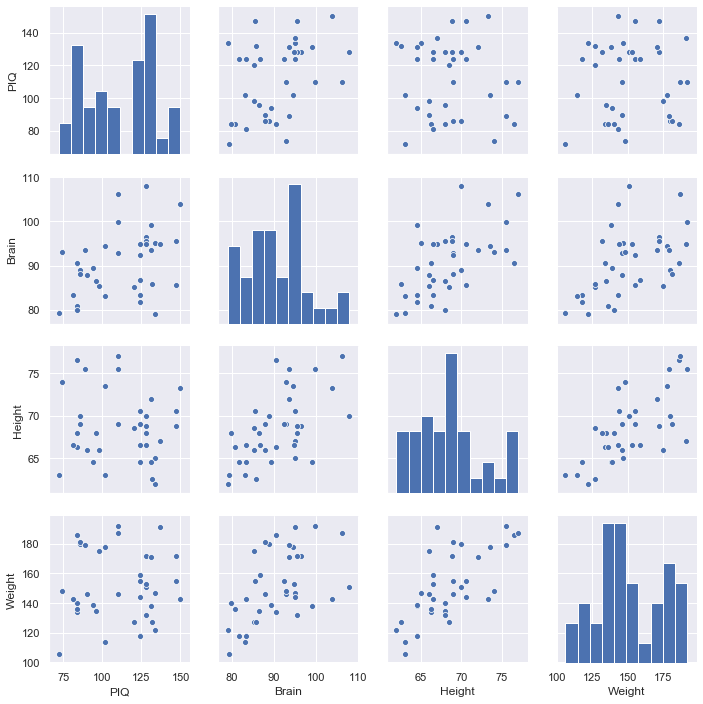

In [19]:
iqsize = pandas.read_csv("iqsize.txt", sep = ' ')
seaborn.pairplot(data = iqsize)
plt.show()

In [20]:
iqsize.corr(method='pearson')

,PIQ,Brain,Height,Weight
PIQ,1.000000,0.377815,-0.093156,0.002512
Brain,0.377815,1.000000,0.588367,0.513487
Height,-0.093156,0.588367,1.000000,0.699614
Weight,0.002512,0.513487,0.699614,1.000000


In [21]:
t, p = stats.pearsonr(iqsize['PIQ'], iqsize['Brain'])
print("Pearson's correlation coefficient: %s, p-value: %s" % (t, p))

Pearson's correlation coefficient: 0.37781546250644005, p-value: 0.01935431879041525


In [22]:
model = ols("PIQ ~ Brain + Height + Weight", iqsize).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    PIQ   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     4.741
Date:                Wed, 27 Nov 2019   Prob (F-statistic):            0.00722
Time:                        14:14:35   Log-Likelihood:                -165.25
No. Observations:                  38   AIC:                             338.5
Df Residuals:                      34   BIC:                             345.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    111.3536     62.971      1.768      0.0